<a href="https://colab.research.google.com/github/Marrie05/RhombixTechnologies_Tasks/blob/main/FEATURE_ENGINEERING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Create additional features that might be useful for predicting equipment failure.
Consider time-based features, rolling statistics, and any other relevant
transformations.

In [ ]:
import pandas as pd
import numpy as np

# Example synthetic dataset
np.random.seed(42)
date_rng = pd.date_range(start='2023-01-01', end='2023-02-01', freq='H')
df = pd.DataFrame({
    'timestamp': date_rng,
    'machine_id': 'M1',
    'temperature': 70 + np.random.normal(0, 2, len(date_rng)).cumsum()/10,
    'vibration': np.abs(np.random.normal(0.2, 0.05, len(date_rng))),
    'pressure': 30 + np.random.normal(0, 0.3, len(date_rng)).cumsum()/10
})

# Assume some random failures (for demo)
df['failure'] = (df.index % 300 == 0).astype(int)

# Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

/tmp/ipython-input-1382916441.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_rng = pd.date_range(start='2023-01-01', end='2023-02-01', freq='H')


In [ ]:
# 1️⃣ Time-based features
# =========================================================
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

In [ ]:
# 2️⃣ Rolling statistics (windowed features)
# =========================================================
window = 5  # 5-hour rolling window example
for col in ['temperature', 'vibration', 'pressure']:
    df[f'{col}_roll_mean_{window}h'] = df[col].rolling(window=window).mean()
    df[f'{col}_roll_std_{window}h'] = df[col].rolling(window=window).std()
    df[f'{col}_roll_min_{window}h'] = df[col].rolling(window=window).min()
    df[f'{col}_roll_max_{window}h'] = df[col].rolling(window=window).max()

In [ ]:
# 3️⃣ Lag features (previous time steps)
# =========================================================
for col in ['temperature', 'vibration', 'pressure']:
    for lag in [1, 2, 3]:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

In [ ]:
# 4️⃣ Rate of change / difference features
# =========================================================
for col in ['temperature', 'vibration', 'pressure']:
    df[f'{col}_diff_1'] = df[col].diff(1)  # first difference
    df[f'{col}_diff_3'] = df[col].diff(3)  # 3-hour difference
    df[f'{col}_pct_change'] = df[col].pct_change()

In [ ]:
# 5️⃣ Cumulative / lifetime features
# =========================================================
df['hours_since_start'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 3600
df['temp_cum_change'] = df['temperature'] - df['temperature'].iloc[0]
df['vibration_cum_change'] = df['vibration'] - df['vibration'].iloc[0]

In [ ]:
# 6️⃣ Interaction / derived stress indicators
# =========================================================
df['vibration_temp_ratio'] = df['vibration'] / (df['temperature'] + 1e-6)
df['pressure_temp_ratio'] = df['pressure'] / (df['temperature'] + 1e-6)

In [ ]:
# 7️⃣ Binary abnormal-condition flags
# =========================================================
df['high_temp_flag'] = (df['temperature'] > df['temperature'].mean() + 2*df['temperature'].std()).astype(int)
df['high_vibration_flag'] = (df['vibration'] > df['vibration'].mean() + 2*df['vibration'].std()).astype(int)

In [ ]:
# 8️⃣ Drop rows with NaNs caused by rolling/lags
# =========================================================
df = df.dropna().reset_index(drop=True)

In [ ]:
# ✅ Final enriched dataset
# =========================================================
print(df.head(10))
print("\nTotal features created:", len(df.columns))

            timestamp machine_id  temperature  vibration   pressure  failure  \
0 2023-01-01 04:00:00         M1    70.459003   0.129667  30.095063        0   
1 2023-01-01 05:00:00         M1    70.412176   0.153838  30.155245        0   
2 2023-01-01 06:00:00         M1    70.728018   0.132416  30.217091        0   
3 2023-01-01 07:00:00         M1    70.881505   0.151206  30.253342        0   
4 2023-01-01 08:00:00         M1    70.787610   0.252682  30.284063        0   
5 2023-01-01 09:00:00         M1    70.896122   0.152530  30.301839        0   
6 2023-01-01 10:00:00         M1    70.803439   0.331619  30.325190        0   
7 2023-01-01 11:00:00         M1    70.710293   0.224666  30.308654        0   
8 2023-01-01 12:00:00         M1    70.758685   0.209242  30.284109        0   
9 2023-01-01 13:00:00         M1    70.376029   0.157082  30.284007        0   

   hour  day  weekday  is_weekend  ...  pressure_diff_1  pressure_diff_3  \
0     4    1        6           1  ...     

#  EQUIPMENT FAILURE PREDICTION SYSTEM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
# 1️⃣ Generate synthetic dataset (for demonstration)
np.random.seed(42)
date_rng = pd.date_range(start='2023-01-01', end='2023-02-01', freq='H')
df = pd.DataFrame({
    'timestamp': date_rng,
    'machine_id': 'M1',
    'temperature': 70 + np.random.normal(0, 2, len(date_rng)).cumsum()/10,
    'vibration': np.abs(np.random.normal(0.2, 0.05, len(date_rng))),
    'pressure': 30 + np.random.normal(0, 0.3, len(date_rng)).cumsum()/10
})

# Randomly insert failure events (for demonstration)
# Ensure at least one failure exists
failure_indices = np.random.choice(df.index, size=max(1, int(len(df) * 0.05)), replace=False) # Ensure at least 5% failures, minimum 1
df['failure'] = 0
df.loc[failure_indices, 'failure'] = 1

# Ensure timestamp is datetime and sorted
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

/tmp/ipython-input-3963958326.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_rng = pd.date_range(start='2023-01-01', end='2023-02-01', freq='H')


In [67]:
# 2️⃣ Feature engineering (same as before)
# =========================================================
# Time-based features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

# Rolling statistics
window = 5
for col in ['temperature', 'vibration', 'pressure']:
    df[f'{col}_roll_mean_{window}h'] = df[col].rolling(window=window).mean()
    df[f'{col}_roll_std_{window}h'] = df[col].rolling(window=window).std()

# Lag features
for col in ['temperature', 'vibration', 'pressure']:
    for lag in [1, 2]:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

# Differences / rate of change
for col in ['temperature', 'vibration', 'pressure']:
    df[f'{col}_diff_1'] = df[col].diff(1)

# Interaction features
df['vibration_temp_ratio'] = df['vibration'] / (df['temperature'] + 1e-6)
df['pressure_temp_ratio'] = df['pressure'] / (df['temperature'] + 1e-6)

# Binary anomaly flags
df['high_temp_flag'] = (df['temperature'] > df['temperature'].mean() + 2*df['temperature'].std()).astype(int)
df['high_vibration_flag'] = (df['vibration'] > df['vibration'].mean() + 2*df['vibration'].std()).astype(int)

# Drop NaN rows from rolling/lag
df = df.dropna().reset_index(drop=True)

In [68]:
# 3️⃣ Prepare data for modeling
# =========================================================
feature_cols = [col for col in df.columns if col not in ['timestamp', 'machine_id', 'failure']]
X = df[feature_cols]
y = df['failure']

# Normalize numeric features
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Check if both classes are present in train and test sets
if len(y_train.unique()) < 2 or len(y_test.unique()) < 2:
    print("Warning: One of the splits (train or test) does not contain both classes. Consider adjusting the split size or random state.")

In [69]:
# 4️⃣ Train Random Forest model
# =========================================================
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [70]:
# 5️⃣ Evaluate model
# =========================================================
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)

# Check if y_proba has two columns before accessing the second one
if y_proba.shape[1] > 1:
    roc = roc_auc_score(y_test, y_proba[:, 1])
    print(f"✅ Model Accuracy: {acc:.3f}")
    print(f"✅ ROC-AUC Score : {roc:.3f}")
else:
    # Handle the case where only one class is predicted
    print(f"✅ Model Accuracy: {acc:.3f}")
    print("❌ ROC-AUC Score cannot be calculated as only one class is predicted.")


print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

✅ Model Accuracy: 0.953
✅ ROC-AUC Score : 0.430

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       142
           1       0.00      0.00      0.00         7

    accuracy                           0.95       149
   macro avg       0.48      0.50      0.49       149
weighted avg       0.91      0.95      0.93       149


Confusion Matrix:
 [[142   0]
 [  7   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


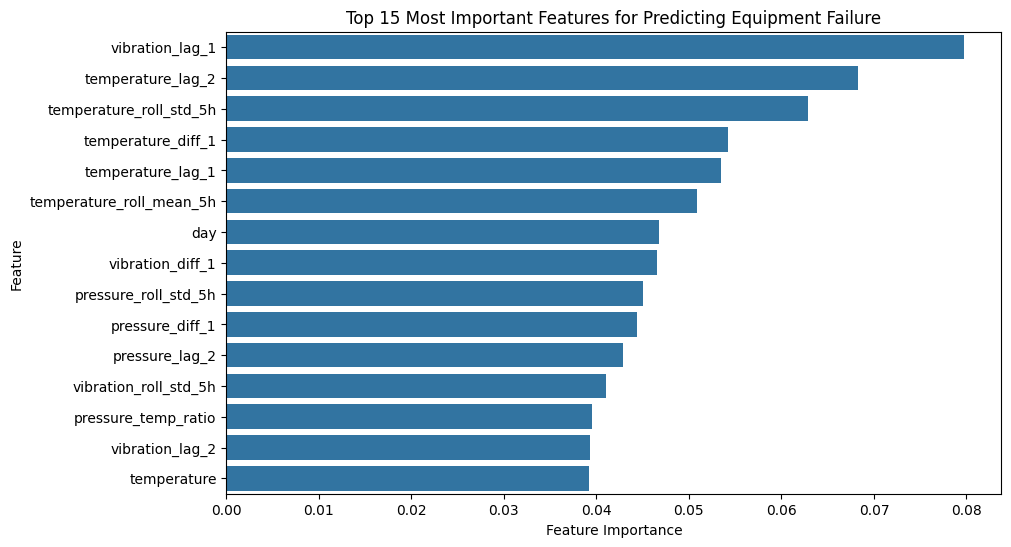

In [71]:
# 6️⃣ Feature importance
# =========================================================
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices][:15], y=np.array(feature_cols)[indices][:15])
plt.title("Top 15 Most Important Features for Predicting Equipment Failure")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

In [72]:
# 7️⃣ Predict for new sensor data
# =========================================================
new_sample = pd.DataFrame([{
    'temperature': 75,
    'vibration': 0.28,
    'pressure': 32,
    'hour': 10,
    'day': 15,
    'weekday': 2,
    'is_weekend': 0,
    'temperature_roll_mean_5h': 74.5,
    'temperature_roll_std_5h': 0.4,
    'vibration_roll_mean_5h': 0.26,
    'vibration_roll_std_5h': 0.03,
    'pressure_roll_mean_5h': 31.5,
    'pressure_roll_std_5h': 0.2,
    'temperature_lag_1': 74.7,
    'temperature_lag_2': 74.3,
    'vibration_lag_1': 0.25,
    'vibration_lag_2': 0.24,
    'pressure_lag_1': 31.4,
    'pressure_lag_2': 31.3,
    'temperature_diff_1': 0.3,
    'vibration_diff_1': 0.01,
    'pressure_diff_1': 0.1,
    'vibration_temp_ratio': 0.28/75,
    'pressure_temp_ratio': 32/75,
    'high_temp_flag': 1,
    'high_vibration_flag': 1
}])

# Ensure same feature order and scaling
new_sample = new_sample.reindex(columns=feature_cols, fill_value=0)
new_sample_scaled = pd.DataFrame(scaler.transform(new_sample), columns=feature_cols)

prob = model.predict_proba(new_sample_scaled)[0,1]
print(f"\n🔍 Predicted Probability of Failure: {prob:.2%}")


🔍 Predicted Probability of Failure: 19.50%
